In [1]:
#import required modules
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import scipy as sp
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#Read in the datasets
train = pd.read_csv('###############')
test = pd.read_csv('################')

# Alexis Cook's Model
    
Using the method in Alexis Cook's tutorial, we were able to achieve and accuracy of:

0.77511.

We can likely improve on this model. My first thought is that we should explore the data to see if we can impove our feature selection to train the model on more and perhaps more informative features. Additionally, we might dicover that there are preprocessing tools that might impove out

# Exploratory Data Analysis

In [2]:
#View the data
#It appears that some features may be unique identifiers
#Such as, Ticket and PassengerId
#cabin is a unique identifier but it may incode useful spatial information
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#Look for any suspicious data. Fare having a minimum 
#of zero could be an indication of missing values or 
#maybe workers were listed as having zero fare.
#Maybe some got compliminetery tickets.
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
#Very few people got complintary tickets on the titanic so I will 
#only consider that the zeros may be explained by workers.
#That assumes that crew are on this list
#Whats the probability that <=1.6% of the training sample is crew given that 
#our data is a random sample of everyone on the titanic?

#36% of the population were workers
#1.6% of the sample is workers
true_prop = (900/2435)
sample_prop = (15/891)
#The sample population had 891 individuals
#The population had 2435 individuals
sample_pop = 891
pop = 2435

#np is over 10
#n(1-p) is over 10
#we can use approximate as normal distribution
z = (sample_prop-true_prop)/np.sqrt((true_prop*(1-true_prop))/sample_pop)
#What is the probability that P(z<-21)?
p = sp.stats.norm.cdf(z)

print(f"n*p = {sample_pop*sample_prop}")
print(f"n*(1-p) = {sample_pop*(1-sample_prop)}")
print(f"Z = {z}")
print(" ")
print(f"The probability that we would sample less that 15 workers out of 891 from the titanic is {(p*100):0.2}%")
print(" ")
print("Definitly not explainable as crew!")

n*p = 15.0
n*(1-p) = 876.0
Z = -21.815239023824546
 
The probability that we would sample less that 15 workers out of 891 from the titanic is 8.3e-104%
 
Definitly not explainable as crew!


In [5]:
#store all feature names for indexing
all_features = list(train.columns)
percent_incomplete = []
#count the number of missing values in each coloumn
print("Name and number of missing elements for each feature.")
print(" ")
for col in all_features:
    num_nan = train[col].isna().sum()
    print(f"{col}: {num_nan}")
    perc = (num_nan/len(train[col]))
    percent_incomplete.append((col,perc))

Name and number of missing elements for each feature.
 
PassengerId: 0
Survived: 0
Pclass: 0
Name: 0
Sex: 0
Age: 177
SibSp: 0
Parch: 0
Ticket: 0
Fare: 0
Cabin: 687
Embarked: 2


In [6]:
#find percent missing elements per feature 
for feat in percent_incomplete:
    print(f"{feat[0]} is {feat[1]:.1%} inclompete")

PassengerId is 0.0% inclompete
Survived is 0.0% inclompete
Pclass is 0.0% inclompete
Name is 0.0% inclompete
Sex is 0.0% inclompete
Age is 19.9% inclompete
SibSp is 0.0% inclompete
Parch is 0.0% inclompete
Ticket is 0.0% inclompete
Fare is 0.0% inclompete
Cabin is 77.1% inclompete
Embarked is 0.2% inclompete


C:\Users\Monty\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Monty\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


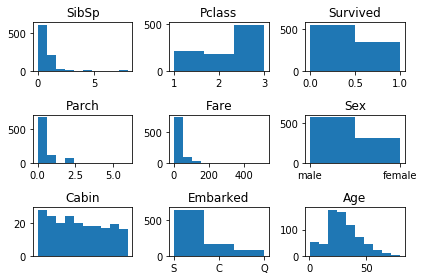

In [7]:
#Plot histograms of each feature (excluding unique features like ticket number)
fig, axs = plt.subplots(3,3);

axs[0,0].hist(train["SibSp"])
axs[0,0].set_title("SibSp");

axs[0,1].hist(train["Pclass"], bins = 3);
axs[0,1].set_title("Pclass");

axs[0,2].hist(train["Survived"], bins = 2)
axs[0,2].set_title("Survived");


axs[1,0].hist(train["Parch"]);
axs[1,0].set_title("Parch");

axs[1,1].hist(train["Fare"]);
axs[1,1].set_title("Fare");


axs[1,2].hist(train["Sex"], bins = 2)
axs[1,2].set_title("Sex");

axs[2,0].hist(train["Cabin"].dropna(0));
axs[2,0].set_title("Cabin");
axs[2,0].get_xaxis().set_visible(False)

axs[2,1].hist(train["Embarked"].dropna(0), bins = 3);
axs[2,1].set_title("Embarked");

axs[2,2].hist(train["Age"]);
axs[2,2].set_title("Age");

plt.tight_layout()

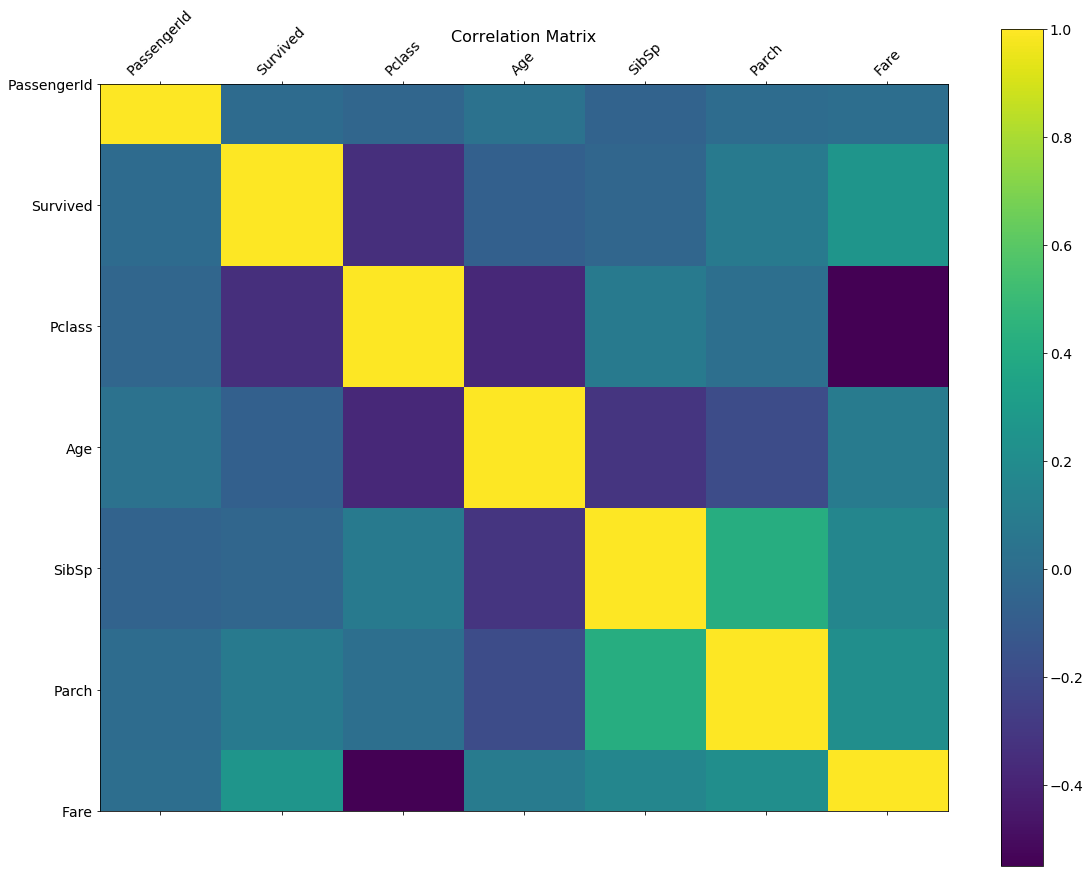

In [8]:
#plot correlation matrix
f = plt.figure(figsize=(19, 15))
plt.matshow(train.corr(), fignum=f.number)
plt.xticks(range(train.select_dtypes(['number']).shape[1]), train.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(train.select_dtypes(['number']).shape[1]), train.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

# Exploratory Data Analysis: Results

From our small exploratoration of the data, we've learned the following. These insights are as follows:

1. We know intuitivly that some of our features, such as Name, PassengerId, Ticket, and Embark are unique or arbitrary enough that they dont yeild any information about survival. Cabin seems arbitrary, but if we can gleam spatial information out of it and passengers in sertain sections were more likely to die, it could be informative.

2. Some features have missing values. For the most part, this isn't to much of a problem. However, Cabin is over 77% missing data and should therefor be excluded from the model. And we have reaon to belive that there are some missing values inthe Fare feature.

3. Features such as Parch and Age are skewed. Other features are very different in scale. As we are using a tree based classifier, this won't be an issue. It should still be noted for when we apply different models in the future.

4. We have both numerical, ordenal, and categorical features. We should not encode these for random forest but may need to for future classifiers.

# Preprocessing
Based on this preliminary exploration. I will not consider Name, PassengerId, Ticket, Embarked, and Cabin from the training. Our only preprocessing step for random forest is to remove unwanted features and deal with the missing values for age. We will assume that the missing values in Age and Fare are Missing at Random and Missing Completly at random. We will use an iterative multivatiate imputer here. In the future, we will make a few more assumtions about the data in order to fill the data using Markov Chain Monte Carlo methods to impute the data. Its overkill for this problem but MCMC was one of my favorite courses in undergrad.

In [9]:
test_feat = ['Age', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp']
features = ['Survived','Age', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp']

In [10]:
#convert catigorical sex to categorica int for classification
train["Sex"] = train["Sex"].replace({"male": 0, "female": 1})

#convert catigorical sex to categorica int for classification
test["Sex"] = test["Sex"].replace({"male": 0, "female": 1})



#convert zeros in fare to NaN for imputer
#loop because find and replace has trouble w/ float zeros
count = 0
for i,elem in enumerate(train["Fare"]):
    if elem < 0.001:
        train["Fare"][i] = math.nan


        
#convert zeros in fare to NaN for imputer
#loop because find and replace has trouble w/ float zeros
count = 0
for i,elem in enumerate(test["Fare"]):
    if elem < 0.001:
        test["Fare"][i] = math.nan

C:\Users\Monty\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Monty\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
#Impute missing values in fare and age

imputed_data = []                    
for df in [train,test]:
    
    imputed_df = df.copy()      
    numerical = ['Age','Fare']                                                     
    

    #define an imputer for numerical columns
    imp_num = IterativeImputer(estimator=RandomForestRegressor(),
                               initial_strategy='median',
                               max_iter=10,
                               random_state=0)

 
    #impute the numerical column(Age)
    imputed_df[numerical] = imp_num.fit_transform(imputed_df[numerical])

    
    imputed_df['Age'] = imputed_df['Age'].apply(lambda x:int(round(x,0)))
    
    imputed_data.append(imputed_df)
    
train = imputed_data[0]  
test = imputed_data[1]

C:\Users\Monty\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


# Train and Run

In [12]:
#encode categorical attributes
X = train[features]
X_test = test[test_feat]

#define output for training
y = X["Survived"]
x = X[test_feat]
#build and fit model
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(x, y)

#apply model to test objects
predictions = model.predict(X_test)

#save predictions
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
output.to_csv('my_submission_preprocessing_unencoded.csv', index=False)